# Investigating factors related to quality in Portuguese Wines

This dataset contains the results of 11 common physicochemical tests on a selection of 6,497 wines from Northwest Portugal. It was assembled with the goal of helping understand what factors impact quality in wine, something I'll also be looking into in this notebook.

URL: https://archive.ics.uci.edu/dataset/186/wine+quality

## Initial Exploration
Firstly let's retreive the data and take a look at it.

In [9]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

In [10]:
wine_quality_dataset = fetch_ucirepo(id=186) # This line may hang for a bit, it's a ~80mb data set

wine_quality_dataset.data.keys()


dict_keys(['ids', 'features', 'targets', 'original', 'headers'])

So we see that there are 5 parts to this data set.
- `ids` is a `None` value in this instance
- `features` is the physiochemical details minus the ratings
- `targets` is just the ratings on their own
- `original` is all of the data together
- `headers` is all of the header values for the `originals` data set

Now if we were training a model to predict quality then keeping out data seperated into `features` and `targets` would be useful. But since we're just exploring we're going to focus on the whole dataset, as stored in `original`.

In [11]:
wine_quality: pd.DataFrame = wine_quality_dataset.data.original

wine_quality.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


As we see it contains a row id, 11 physiochemical test results, the rating, and the colour. For 14 columns total.

Let's take a look at some of those numbers now:

In [12]:
wine_quality.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


The first thing I notice is the counts, they all have the same count and it's the number we expect from the description of the dataset. This means no missing values. Secondly, I notice that the `color` header is gone-- as a catagorical variable it's not included in `describe`.

Let's check how many of each color we have.

In [13]:
wine_quality.color.value_counts()

color
white    4898
red      1599
Name: count, dtype: int64

So we see that there are roughly three time as many whites as reds in this dataset, and that the sum is what we expect.

There are some other things that jump out from that description, but it's hard to really understand just from summary statistics. So let's try some visualisations. 

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

## Wine Quality Scores
Now that we have our graphing packages let's take a look at the quality metric.

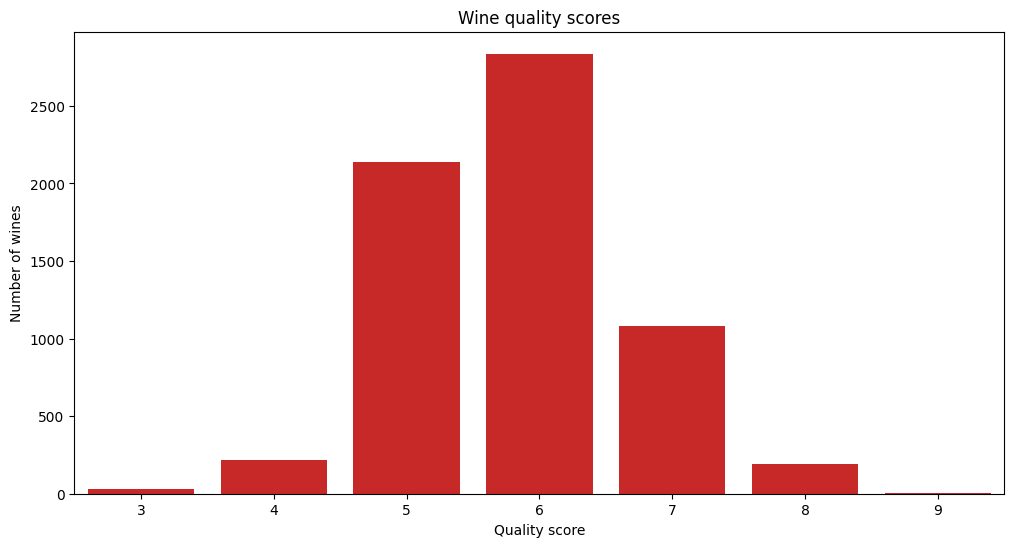

quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64

In [30]:
quality_counts = wine_quality["quality"].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.countplot(data=wine_quality, x="quality", color="#e10e0e")
plt.title("Wine quality scores")
plt.xlabel("Quality score")
plt.ylabel("Number of wines")
plt.show()

quality_counts


So dispite being ostensibly a 1-10 scale, nothing gets above a 9 or below a 3. And the mean and median are both above the halfway point.

Let's take a look at which of the physiochemical features seems to correlate most with quality for the overall dataset before we narrow things down.

## Correlations in the overall dataset

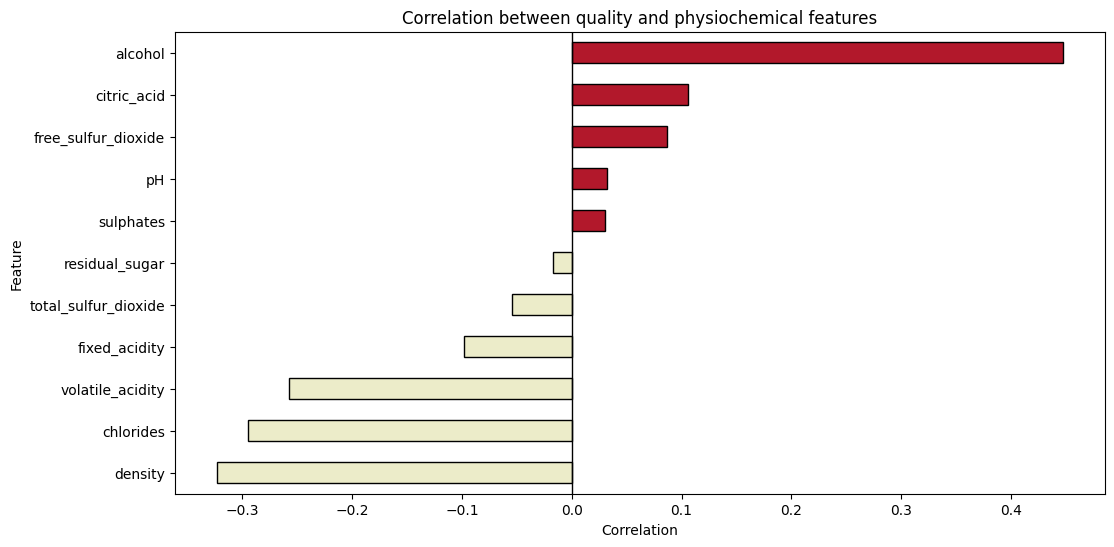

density                -0.322806
chlorides              -0.295054
volatile_acidity       -0.257806
fixed_acidity          -0.098154
total_sulfur_dioxide   -0.054777
residual_sugar         -0.016891
sulphates               0.029831
pH                      0.032538
free_sulfur_dioxide     0.086865
citric_acid             0.105711
alcohol                 0.446925
Name: quality, dtype: float64

In [31]:
def get_quality_correlations(wines: pd.DataFrame)-> pd.Series: # We'll see later why we want this as a function
    return (wines.corr(
        numeric_only=True,
        method='spearman'
        )["quality"]
    .drop(index="quality")
    .sort_values())

quality_correlations = get_quality_correlations(wine_quality)

bar_colors = quality_correlations.apply(
    lambda value: "#ececc9" if value < 0 else "#b2182b"
)

plt.figure(figsize=(12, 6))
quality_correlations.plot(
    kind="barh", color=bar_colors, edgecolor="black"
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Correlation between quality and physiochemical features")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()

quality_correlations


Alcohol, Density, Volatile Acidity, and Chlorides seem to have the most effect, but let's recall that this data contains both whites and reds-- each of which we might expect to be effected by these features differently. Let's try splitting them out and seeing what kind of difference we get.

## Compairing Red and White

In [32]:
red_wine_group, white_wine_group = wine_quality.groupby("color")

red_wines = red_wine_group[1] # TODO: Make sure this works consistantly
white_wines = white_wine_group[1]

del red_wine_group
del white_wine_group

red_wines.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [33]:
white_wines.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


So we see some differences already just by glancing at the data, sugar is higher in whites as we'd expect, but acidity is about the same which suprised me personally. Let's graph these to get a better idea of the differences.

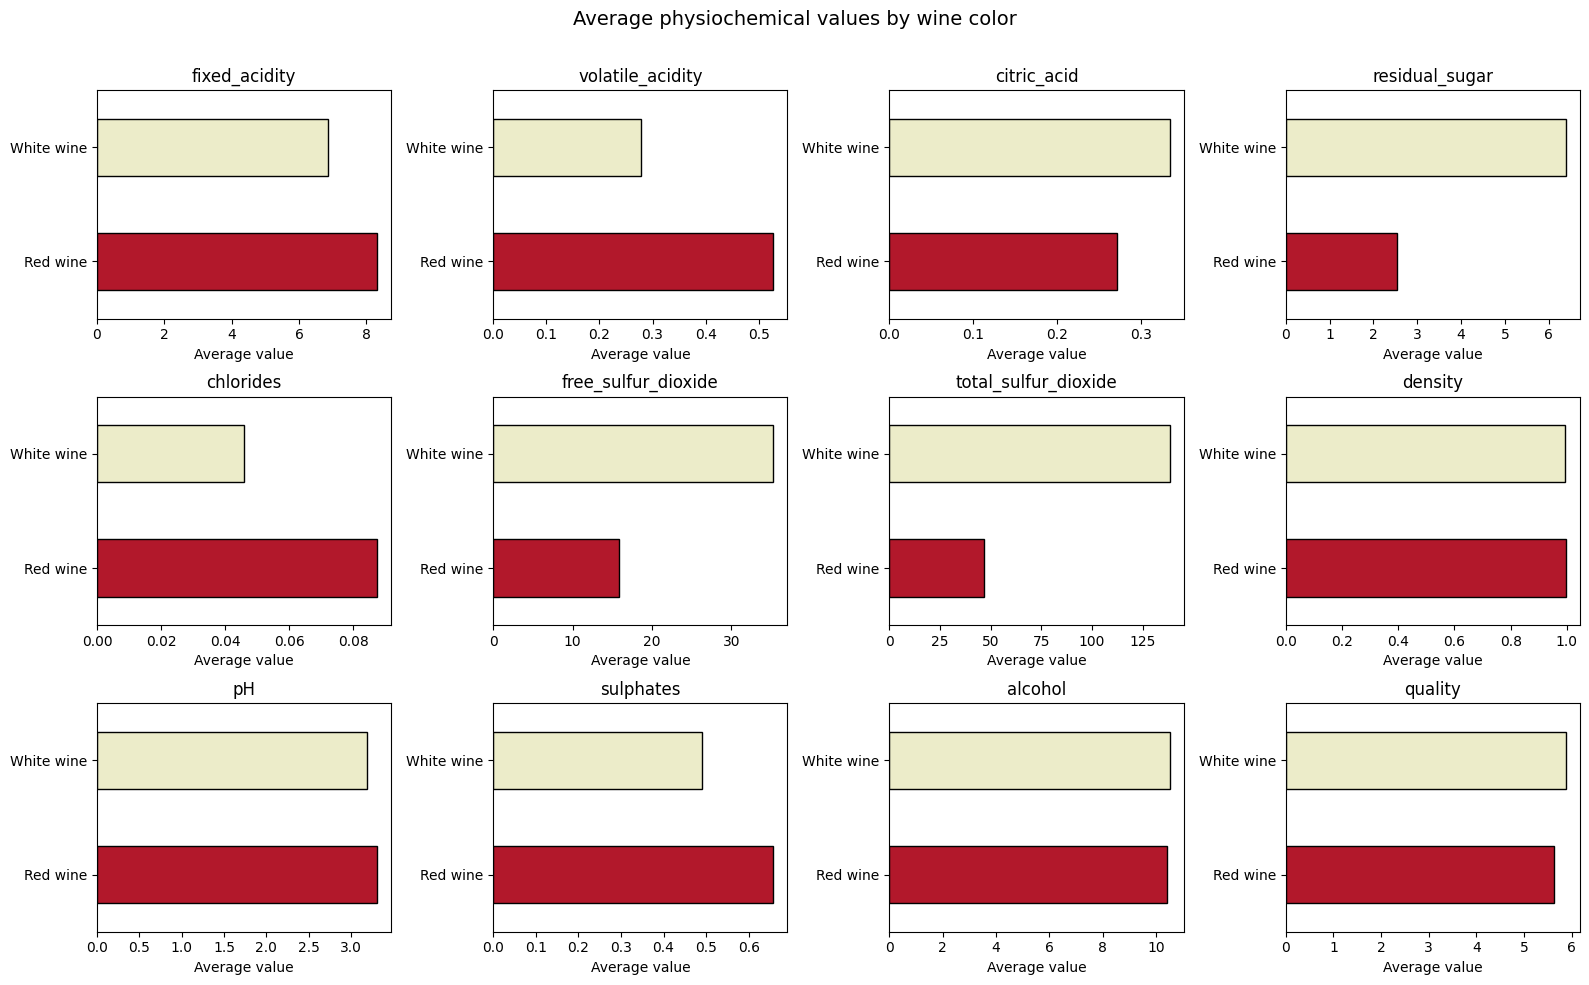

,Red wine,White wine
fixed_acidity,8.319637,6.854788
volatile_acidity,0.527821,0.278241
citric_acid,0.270976,0.334192
residual_sugar,2.538806,6.391415
chlorides,0.087467,0.045772
free_sulfur_dioxide,15.874922,35.308085
total_sulfur_dioxide,46.467792,138.360657
density,0.996747,0.994027
pH,3.311113,3.188267
sulphates,0.658149,0.489847


In [34]:
red_means = red_wines.mean(numeric_only=True)
white_means = white_wines.mean(numeric_only=True)

feature_means = pd.DataFrame({"Red wine": red_means, "White wine": white_means})

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axes = axes.flatten()

for ax, (feature, values) in zip(axes, feature_means.iterrows()):
    values.plot(kind="barh", ax=ax, color=["#b2182b", "#ececc9"], edgecolor="black")
    ax.set_title(feature)
    ax.set_xlabel("Average value")
    ax.set_ylabel("")
    ax.legend().set_visible(False)

for ax in axes[len(feature_means) :]:
    ax.remove()

fig.suptitle("Average physiochemical values by wine color", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

feature_means

So immediatly we see that-- of our four key variables-- Alcohol and Density barely differ, but Volatile Acidity and Chlorides seem to be more assosated with Reds than Whites. Given that those were negative correlations we might expect to see a lower average quality amoung the Reds, which we do, but only barely (~0.24). So instead let's see how correlation with quality differs between Reds and Whites.

In [35]:
red_corr = get_quality_correlations(red_wines)
red_corr

volatile_acidity       -0.380647
total_sulfur_dioxide   -0.196735
chlorides              -0.189922
density                -0.177074
free_sulfur_dioxide    -0.056901
pH                     -0.043672
residual_sugar          0.032048
fixed_acidity           0.114084
citric_acid             0.213481
sulphates               0.377060
alcohol                 0.478532
Name: quality, dtype: float64

In [36]:
white_corr = get_quality_correlations(white_wines)
white_corr

density                -0.348351
chlorides              -0.314488
total_sulfur_dioxide   -0.196680
volatile_acidity       -0.196562
fixed_acidity          -0.084485
residual_sugar         -0.082070
citric_acid             0.018333
free_sulfur_dioxide     0.023713
sulphates               0.033319
pH                      0.109362
alcohol                 0.440369
Name: quality, dtype: float64

We can already start to see the differences, but once again let's graph it.

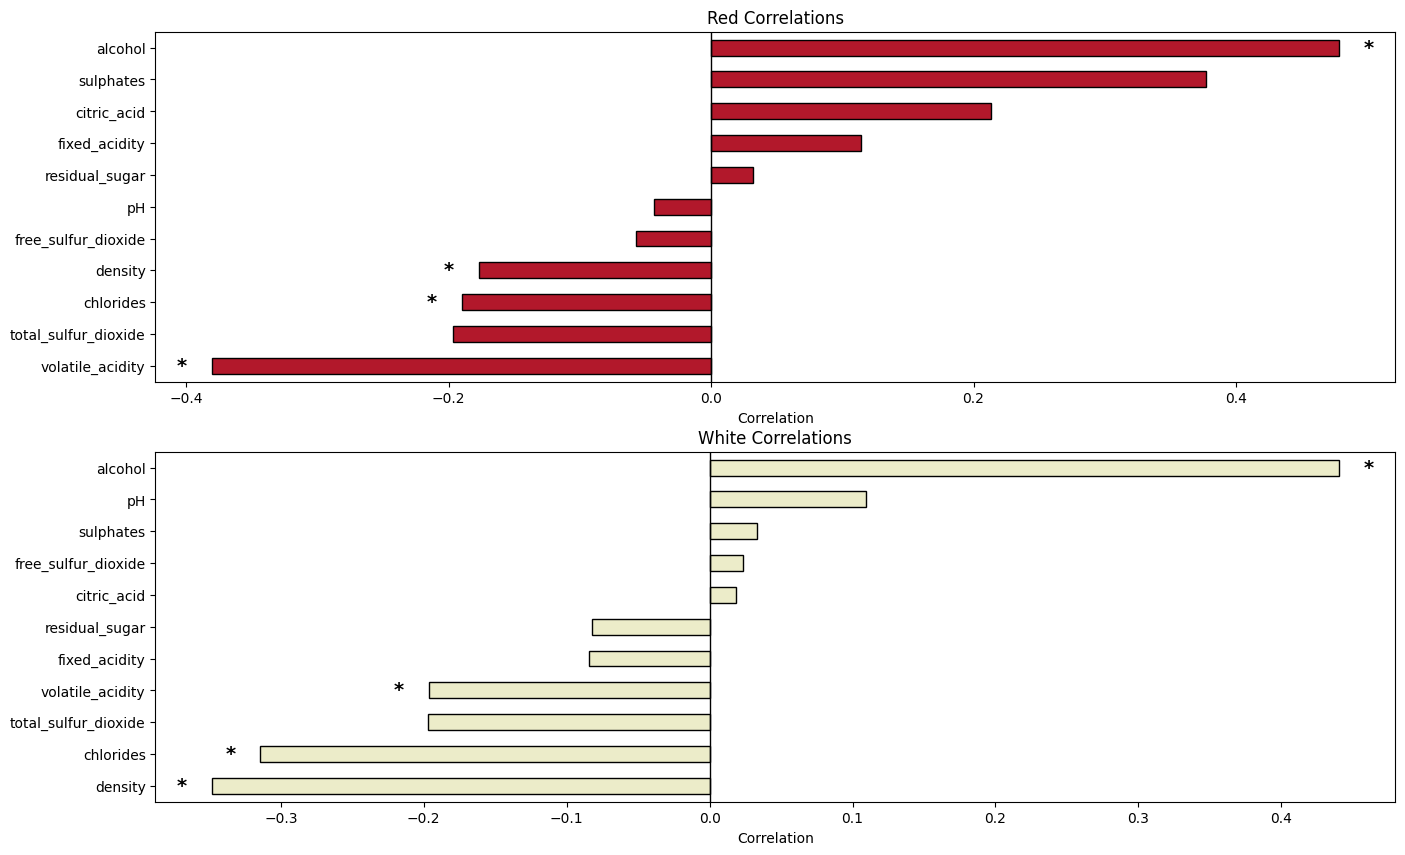

In [37]:
fig, [red_ax, white_ax] = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))


def mark_key_features(ax, correlations):
    highlight_features = {"alcohol", "density", "volatile_acidity", "chlorides"}
    x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
    offset = 0.02 * x_range
    for bar, feature in zip(ax.patches, correlations.index):
        if feature in highlight_features:
            x = bar.get_width()
            y = bar.get_y() + bar.get_height() / 2
            ax.text(
                x + (offset if x >= 0 else -offset),
                y,
                "*",
                va="center",
                ha="left" if x >= 0 else "right",
                fontsize=14,
                fontweight="bold",
                color="black",
            )

red_corr.plot(
    kind="barh",
    ax=red_ax,
    edgecolor="black",
    color="#b2182b"

)
red_ax.set_title("Red Correlations")
red_ax.set_xlabel("Correlation")
red_ax.set_ylabel("")
red_ax.legend().set_visible(False)
red_ax.axvline(0, color="black", linewidth=1)
mark_key_features(red_ax, red_corr)

white_corr.plot(
    kind="barh",
    ax=white_ax,
    edgecolor="black",
    color="#ececc9"
)
white_ax.set_title("White Correlations")
white_ax.set_xlabel("Correlation")
white_ax.set_ylabel("")
white_ax.legend().set_visible(False)
white_ax.axvline(0, color="black", linewidth=1)
mark_key_features(white_ax, white_corr)

plt.show()

I've marked the 4 values-- Alcohol, Density, Volatile Acidity, and Chlorides -- which had the clearest correlation on the overall data set with an asterix.

While white looks quite similar to the overall, as might be expected due to have ~3.5 time the representation in the dataset, red has been significaltly upset, with several new key corrilates.

Before we turn to analysing each of these sub-datasets individually I'd like to look at the curious case of Total Sulfur Dioxide.